devoloping PCA algorithm for dimension reduction

Loading cached PCA results from cache/pca_2_components.pkl...


Loading PCA results: 100%|██████████| 1/1 [00:00<00:00, 223.85file/s]
/tmp/ipykernel_28356/2472208738.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


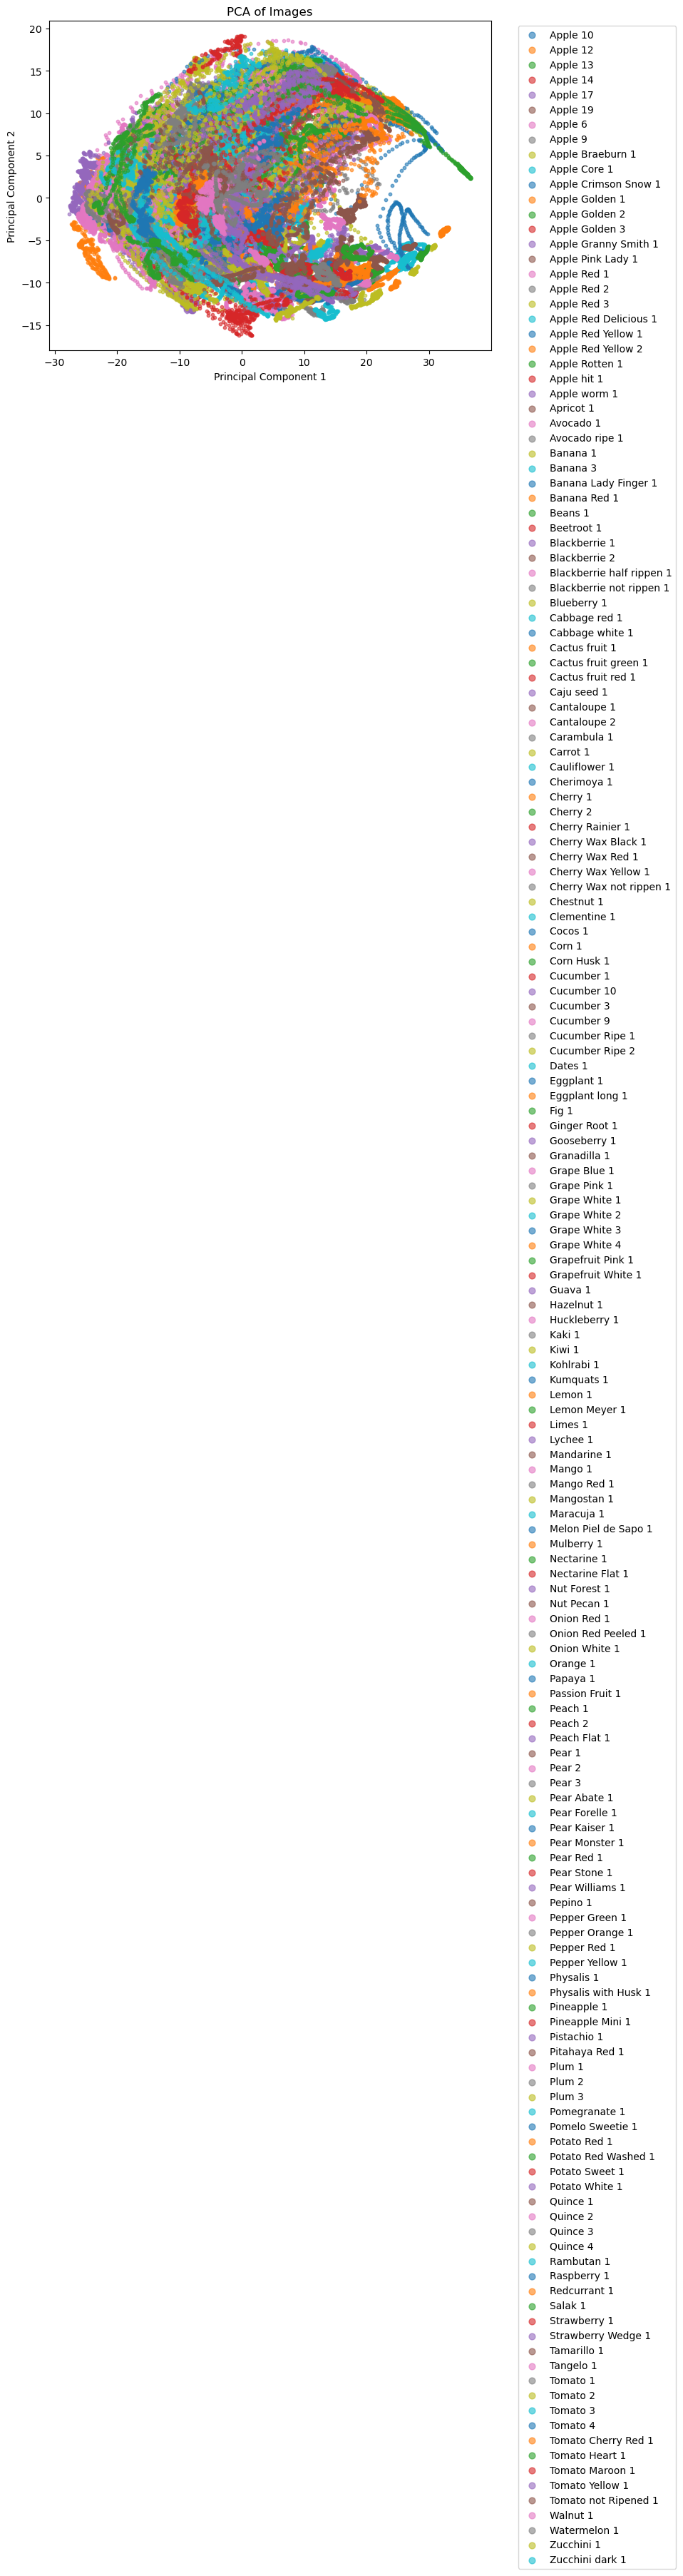

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from os.path import isfile, join
import os
import pickle  # For saving/loading processed data
from tqdm import tqdm

# Cache directory to store processed data
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Import images from the specified path in batches
def import_images_in_batches(path, resize_dim=(50, 50), batch_size=1000):
    cache_file = join(CACHE_DIR, f"images_{resize_dim[0]}x{resize_dim[1]}.pkl")
    if isfile(cache_file):
        try:
            print(f"Loading cached images from {cache_file}...")
            with tqdm(total=1, desc="Loading cached images", unit="file") as pbar:
                with open(cache_file, "rb") as f:
                    images, labels = pickle.load(f)
                pbar.update(1)
        except (EOFError, pickle.UnpicklingError):
            print(f"Corrupted cache file detected: {cache_file}. Deleting it...")
            os.remove(cache_file)
            raise RuntimeError("Cache file was corrupted and has been deleted. Please rerun the script.")
        for i in range(0, len(images), batch_size):
            yield images[i:i + batch_size], labels[i:i + batch_size]
    else:
        print("Processing images...")
        images = []
        labels = []
        folders = os.listdir(path)
        for folder in tqdm(folders, desc="Importing images", unit="folder"):
            folder_path = join(path, folder)
            if os.path.isdir(folder_path):
                files = os.listdir(folder_path)
                for file in tqdm(files, desc=f"Processing {folder}", leave=False, unit="file"):
                    file_path = join(folder_path, file)
                    if isfile(file_path):
                        img = cv2.imread(file_path)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                        img = cv2.resize(img, resize_dim)  # Resize to reduce memory usage
                        images.append(img.flatten())  # Flatten the image
                        labels.append(folder)  # Use folder name as label
        images = np.array(images, dtype=np.float32) / 255.0  # Normalize pixel values
        labels = np.array(labels)
        print(f"Saving processed images to {cache_file}...")
        with tqdm(total=1, desc="Saving images", unit="file") as pbar:
            with open(cache_file, "wb") as f:
                pickle.dump((images, labels), f)
            pbar.update(1)
        for i in range(0, len(images), batch_size):
            yield images[i:i + batch_size], labels[i:i + batch_size]

# Apply Incremental PCA to reduce dimensionality
def apply_incremental_pca(path, n_components=2, resize_dim=(50, 50), batch_size=1000):
    cache_file = join(CACHE_DIR, f"pca_{n_components}_components.pkl")
    if isfile(cache_file):
        print(f"Loading cached PCA results from {cache_file}...")
        with tqdm(total=1, desc="Loading PCA results", unit="file") as pbar:
            with open(cache_file, "rb") as f:
                reduced_images, labels = pickle.load(f)
            pbar.update(1)
    else:
        print("Fitting Incremental PCA...")
        ipca = IncrementalPCA(n_components=n_components)
        labels = []
        reduced_images = []
        batches = list(import_images_in_batches(path, resize_dim, batch_size))
        with tqdm(total=len(batches), desc="Fitting PCA batches", unit="batch") as pbar:
            for images_batch, labels_batch in batches:
                ipca.partial_fit(images_batch)  # Incrementally fit PCA on each batch
                labels.extend(labels_batch)
                pbar.update(1)
        print("Transforming data with Incremental PCA...")
        with tqdm(total=len(batches), desc="Transforming PCA batches", unit="batch") as pbar:
            for images_batch, _ in batches:
                reduced_images.append(ipca.transform(images_batch))  # Transform each batch
                pbar.update(1)
        reduced_images = np.vstack(reduced_images)
        labels = np.array(labels)
        print(f"Saving PCA results to {cache_file}...")
        with tqdm(total=1, desc="Saving PCA results", unit="file") as pbar:
            with open(cache_file, "wb") as f:
                pickle.dump((reduced_images, labels), f)
            pbar.update(1)
    return reduced_images, labels

# Visualize the PCA results
def visualize_pca(reduced_images, labels):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_index[label] for label in labels])
    for i, label in enumerate(unique_labels):
        mask = numeric_labels == i  # Create a boolean mask for filtering
        plt.scatter(reduced_images[mask, 0], reduced_images[mask, 1], label=label, alpha=0.6, s=10)
    plt.title('PCA of Images')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Main function to run Incremental PCA on images
def main():
    path = 'fruits-360/Training'
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return
    reduced_images, labels = apply_incremental_pca(path, n_components=2, resize_dim=(50, 50), batch_size=1000)
    visualize_pca(reduced_images, labels)

if __name__ == "__main__":
    main()